# Portfolio withdrawal analysis

In this Notebook I will analyse how much money I can safely withdraw from the day I retire until my death.

In this experiment I have several groups of hypothetical investors, each with an portfolio worth *portfolio_start_value* SEK the moment they decide to retire. Each group is alloted to one of the following portfolios:

- **Stocks/Bonds 20/80** - 20% in US stocks and 80% in short-, mid- and longterm US Treasury bonds
- **Stocks/Bonds 40/60** - 40% in US stocks and 60% in short-, mid- and longterm US Treasury bonds
- **Stocks/Bonds 60/40** - 60% in US stocks and 40% in short-, mid- and longterm US Treasury bonds
- **Stocks/Bonds 80/20** - 80% in US stocks and 20% in short-, mid- and longterm US Treasury bonds
- **Harry Brownes Permanent Portfolio** - 25% in US stocks, 50% in short- and longterm US Treasury bonds and 25% in gold 
- **US Stocks** - 100% in US stocks
- **Gold** - 100% in gold

Each group is made up of 102 hypothetical investors:

- **The first investor in each group retires in 1871**
- **The second investor in each group retires in 1872**
- **The third investor in each group retires in 1873**
- **And so on until the 102th investor in each group that retires in 1973**

In this Notebook I want to answer the following questions:

- Which portfolio is the safest?
- How much can I safely withdraw from my portfolio each year after retirement?

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from os import path
from datetime import datetime, timedelta
from scipy.stats import norm

In [2]:
def convert_yearly_return_to_numeric(yearly_return_string):
    
    #Check if it is a positive return
    if '+' in yearly_return_string:
        yearly_return_string = yearly_return_string.replace('+', '')
        yearly_return_numeric = float(yearly_return_string)
        yearly_return_numeric = (100 + yearly_return_numeric)/100
        
    else:
        yearly_return_string = yearly_return_string.replace('-', '')
        yearly_return_numeric = float(yearly_return_string)
        yearly_return_numeric = (100 - yearly_return_numeric)/100
    
    return yearly_return_numeric
    

In [3]:
def find_yearly_returns(soup):
    
    result = []
    
    html_table = soup.find('table', id='yearReturns')
    html_table_tbody = html_table.find('tbody')
    html_table_tbody_rows = html_table_tbody.findAll('tr')
    
    for row in html_table_tbody_rows:
        current_year = row.find('td').text
        total = convert_yearly_return_to_numeric(row.find_all('td')[1].text)
        inflation_adjusted = convert_yearly_return_to_numeric(row.find_all('td')[2].text)
        result.append({'year': current_year, 'inflation_adjusted': inflation_adjusted, 'total': total})
        
    return result

In [4]:
def fetch_portfolio_results(portfolio_name):
    base_url = "http://www.lazyportfolioetf.com/allocation"
    portfolio = "stocks-bonds-60-40"
    url = f"{base_url}/{portfolio_name}/"

    req = requests.get(url)
    soup = BeautifulSoup(req.text, "html.parser")
    
    df = pd.DataFrame(find_yearly_returns(soup))
    df['year'] = pd.DatetimeIndex(df['year']).year

    return df

In [5]:
def read_portfolio_results(portfolio_name):
    
    file = r'data/' + portfolio_name + '.csv'
    
    try:
        df = pd.read_csv(file, index_col=None, header=0)
        return df
    except:
        print(f"Data for portfolio {portfolio_name} not found locally...Will scrape it from Lazy ETF")
        df = fetch_portfolio_results(portfolio_name)
        df.to_csv(f"data/{portfolio_name}.csv")
        return df

# Start simulations
Run simulations for withdrawing n % of money from the portfolio each year

In [6]:
#Set start date, number of years, withdrawal rate, etc.
number_of_years_to_withdraw_list = [50, 40, 30]
start_year = datetime(1871, 1, 1).year
last_year_in_data = datetime(2023, 1, 1).year
withdrawal_rates = [0.03, 0.035, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
portfolio_start_value = 500000

portfolios = ['stocks-bonds-40-60', 'stocks-bonds-60-40', 'stocks-bonds-80-20', 'harry-browne-permanent', 'us-stocks', 'gold', 'stocks-bonds-20-80']

In [7]:
def forward_fill_portfolio_value(df, start_year, end_year, withdrawal_rate, portfolio_start_value):
    for i in range(start_year, end_year + 1):
        df.loc[i, 'portfolio_value'] = (df.loc[i-1, 'portfolio_value'] * df.loc[i, 'inflation_adjusted'])
        df.loc[i, 'portfolio_value'] = df.loc[i, 'portfolio_value'] - (portfolio_start_value * withdrawal_rate)
    df = df.set_index(df['year'])
    return df

In [8]:
def withdraw_for_n_years(df, start_year, end_year, withdrawal_rate, portfolio_start_value, portfolio_name, number_of_years_to_withdraw):
    
    df = df[df['year'] <= end_year]
    df = df[df['year'] >= start_year]
    df = df.set_index(df['year'])

    df.loc[start_year, 'portfolio_value'] = portfolio_start_value
    df = forward_fill_portfolio_value(df, start_year + 1, end_year, withdrawal_rate, portfolio_start_value)
    #display(df)
    df = df[df['portfolio_value'] >= (portfolio_start_value * withdrawal_rate)]
    #years_survived = relativedelta(df['Date'].iloc[-1], df['Date'].iloc[0]).years
    
    if(len(df) == 0):
        return {"start_date": start_date, "end_date": None, "years_survival": 0}
    
    return {"start_date": df.iloc[-1]['year'], "end_date": df.iloc[0]['year'], "years_survival": len(df) - 1, "portfolio_end_value": df.iloc[0]['portfolio_value'], "portfolio_name": portfolio_name, "withdrawal_rate": withdrawal_rate, "withdrawal_years": number_of_years_to_withdraw}

In [9]:
result = []

for number_of_years_to_withdraw in number_of_years_to_withdraw_list:
    
    print(f"Running simulations for: {number_of_years_to_withdraw} years")

    for withdrawal_rate in withdrawal_rates:
    
        print(f"Running simulations with withdrawal rate: {withdrawal_rate * 100}%")

        for portfolio_name in portfolios:
  
            print(f"Running simulations on portfolio: {portfolio_name}")
    
            df = fetch_portfolio_results(portfolio_name)

            for current_year in range(start_year, last_year_in_data - number_of_years_to_withdraw):
    
                result.append(withdraw_for_n_years(df, current_year, current_year + number_of_years_to_withdraw, withdrawal_rate, portfolio_start_value, portfolio_name, number_of_years_to_withdraw))
    
results_df = pd.DataFrame(result)
print(f"\033[1mSimulation is finished!\033[0m")

Running simulations for: 50 years
Running simulations with withdrawal rate: 3.0%
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40
Running simulations on portfolio: stocks-bonds-80-20
Running simulations on portfolio: harry-browne-permanent
Running simulations on portfolio: us-stocks
Running simulations on portfolio: gold
Running simulations on portfolio: stocks-bonds-20-80
Running simulations with withdrawal rate: 3.5000000000000004%
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40
Running simulations on portfolio: stocks-bonds-80-20
Running simulations on portfolio: harry-browne-permanent
Running simulations on portfolio: us-stocks
Running simulations on portfolio: gold
Running simulations on portfolio: stocks-bonds-20-80
Running simulations with withdrawal rate: 4.0%
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40


Running simulations on portfolio: stocks-bonds-60-40
Running simulations on portfolio: stocks-bonds-80-20
Running simulations on portfolio: harry-browne-permanent
Running simulations on portfolio: us-stocks
Running simulations on portfolio: gold
Running simulations on portfolio: stocks-bonds-20-80
Running simulations with withdrawal rate: 5.0%
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40
Running simulations on portfolio: stocks-bonds-80-20
Running simulations on portfolio: harry-browne-permanent
Running simulations on portfolio: us-stocks
Running simulations on portfolio: gold
Running simulations on portfolio: stocks-bonds-20-80
Running simulations with withdrawal rate: 6.0%
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40
Running simulations on portfolio: stocks-bonds-80-20
Running simulations on portfolio: harry-browne-permanent
Running simulations on portfolio: us-st

In [10]:
print(results_df.groupby(['portfolio_name', 'withdrawal_rate', 'withdrawal_years']).agg({'years_survival' : ['mean', 'min', 'max', 'median']}).to_string())
print(results_df.groupby(['portfolio_name', 'withdrawal_rate', 'withdrawal_years']).agg({'portfolio_end_value' : ['mean', 'min', 'max', 'median']}).to_string())

                                                        years_survival               
                                                                  mean min max median
portfolio_name         withdrawal_rate withdrawal_years                              
gold                   0.030           30                    25.934426  14  30   30.0
                                       40                    30.116071  14  40   31.0
                                       50                    32.441176  18  50   31.0
                       0.035           30                    24.155738  12  30   26.0
                                       40                    27.196429  12  40   27.0
                                       50                    28.980392  15  50   27.0
                       0.040           30                    22.426230  11  30   23.0
                                       40                    24.526786  11  40   23.5
                                       50             

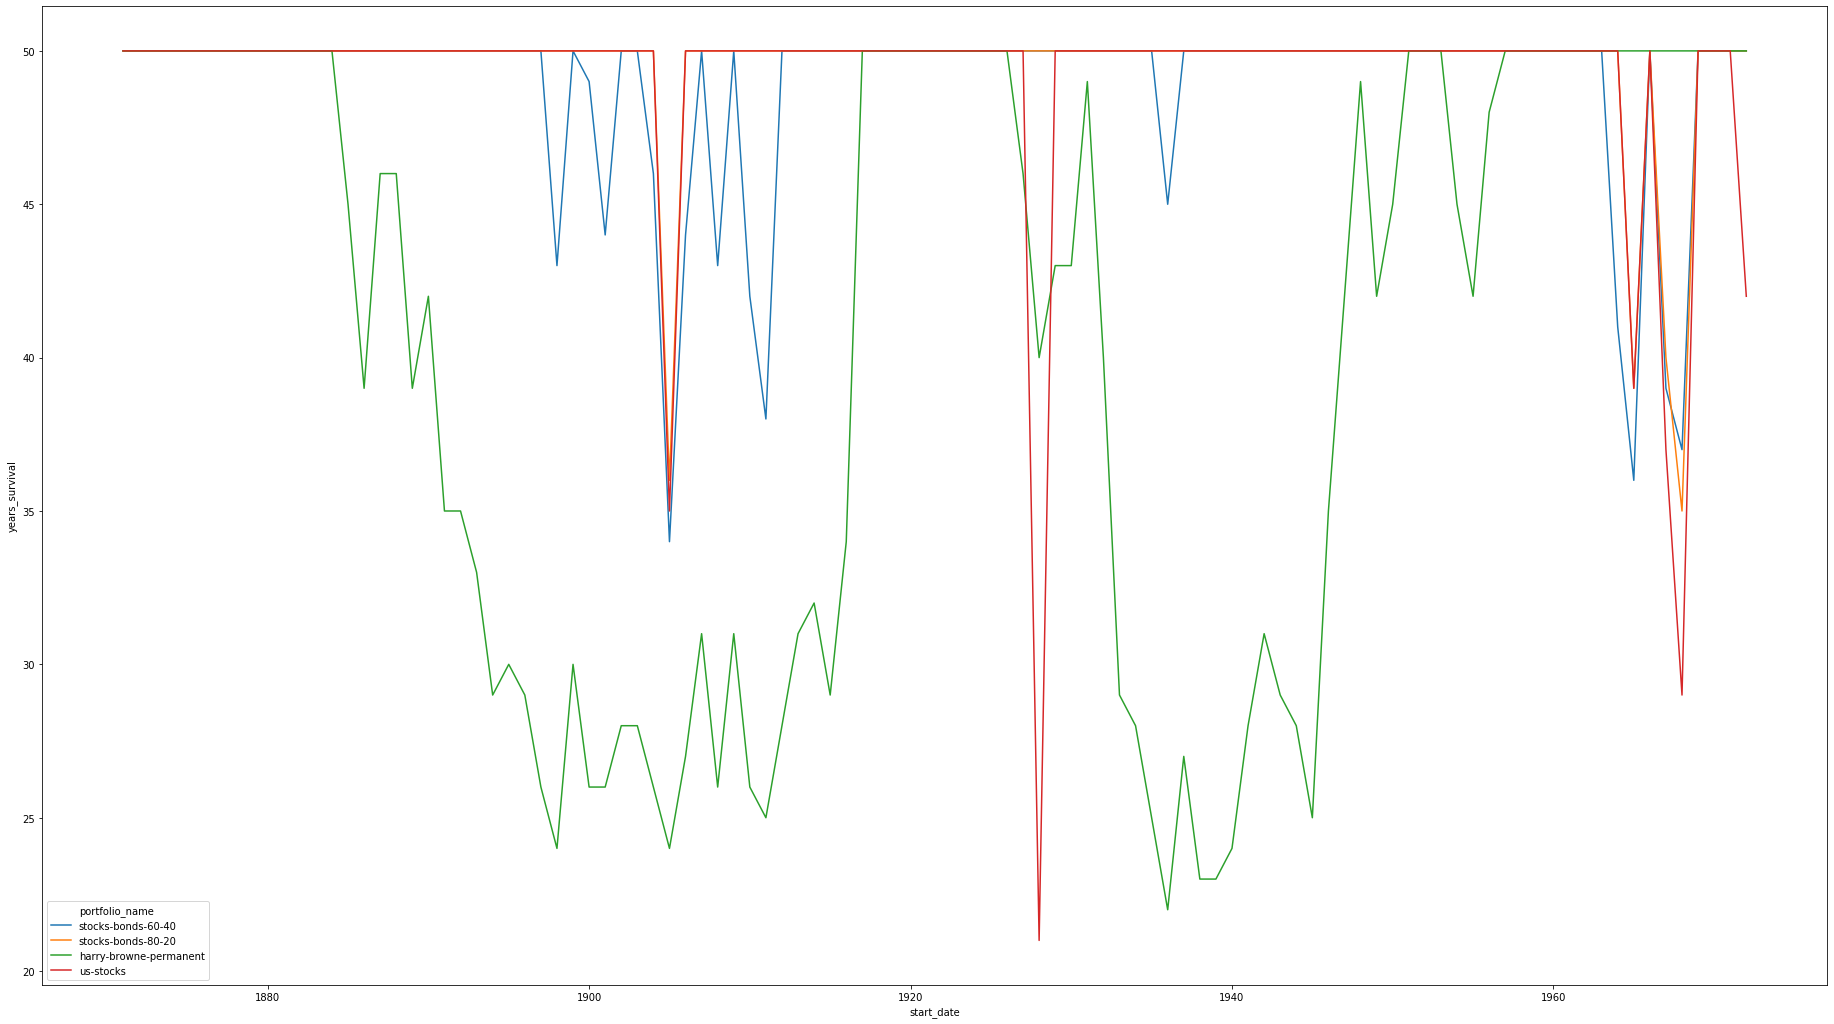

In [47]:
df_to_plot = results_df[(results_df['withdrawal_years'] == 50) & (results_df['withdrawal_rate'] == 0.04) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'us-stocks', 'stocks-bonds-60-40', 'harry-browne-permanent']))]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df_to_plot) 
plt.show()

# Results

Here are the results from the simulations

## Being safe and never risking running out of money

If your objective is to be as safe as possible and have a *very* little risk of running out of money in your portfolio during your retirement years these are the level of withdrawal rates and portfolios you should consider.

Withdrawal rate: <= 3.5%

The graph below shows the longetivitiy of the different portfolios on the y-axis and the year of retirement on the x-axis. As you can see the following portfolios are the safest:

- Stocks/Bonds 80/20
- Stocks/Bonds 60/40
- US Stocks

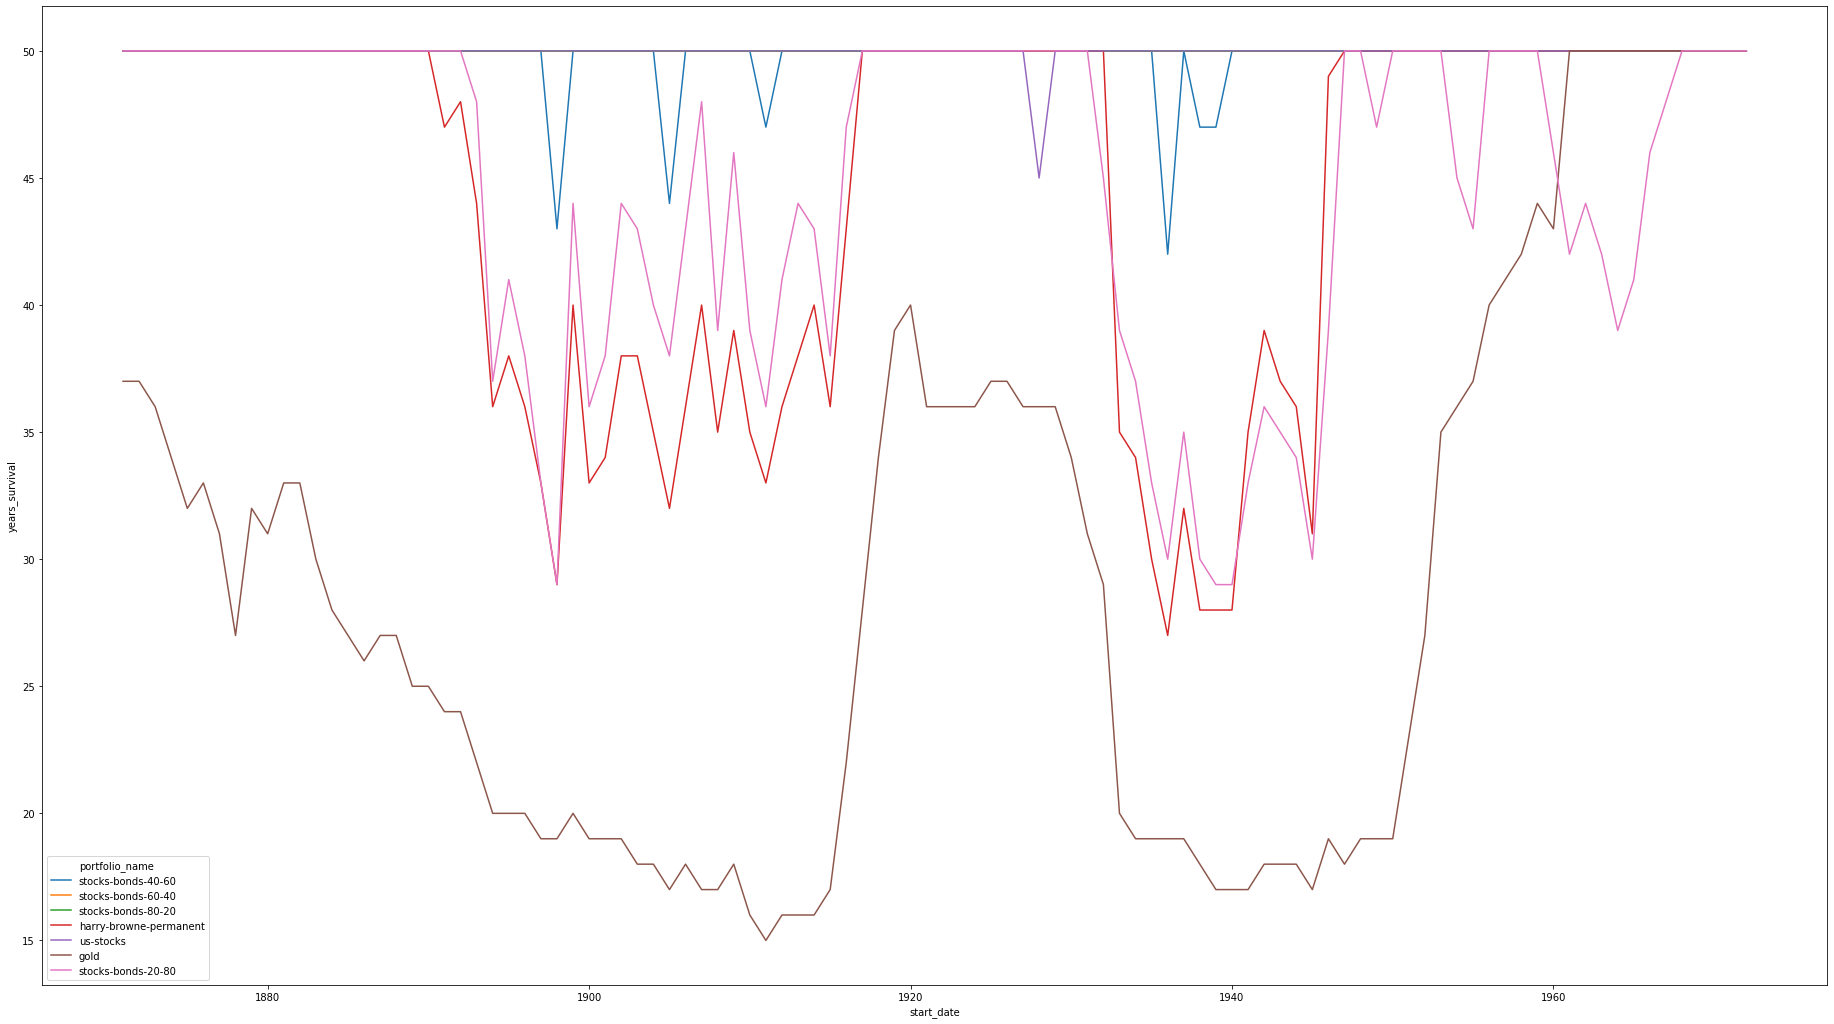

In [11]:
df1 = results_df[(results_df['withdrawal_rate'] == 0.035) & (results_df['withdrawal_years'] == 50)]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df1) 
plt.show()

Lets look at the same graph but with only the three top-performing portfolios visible:

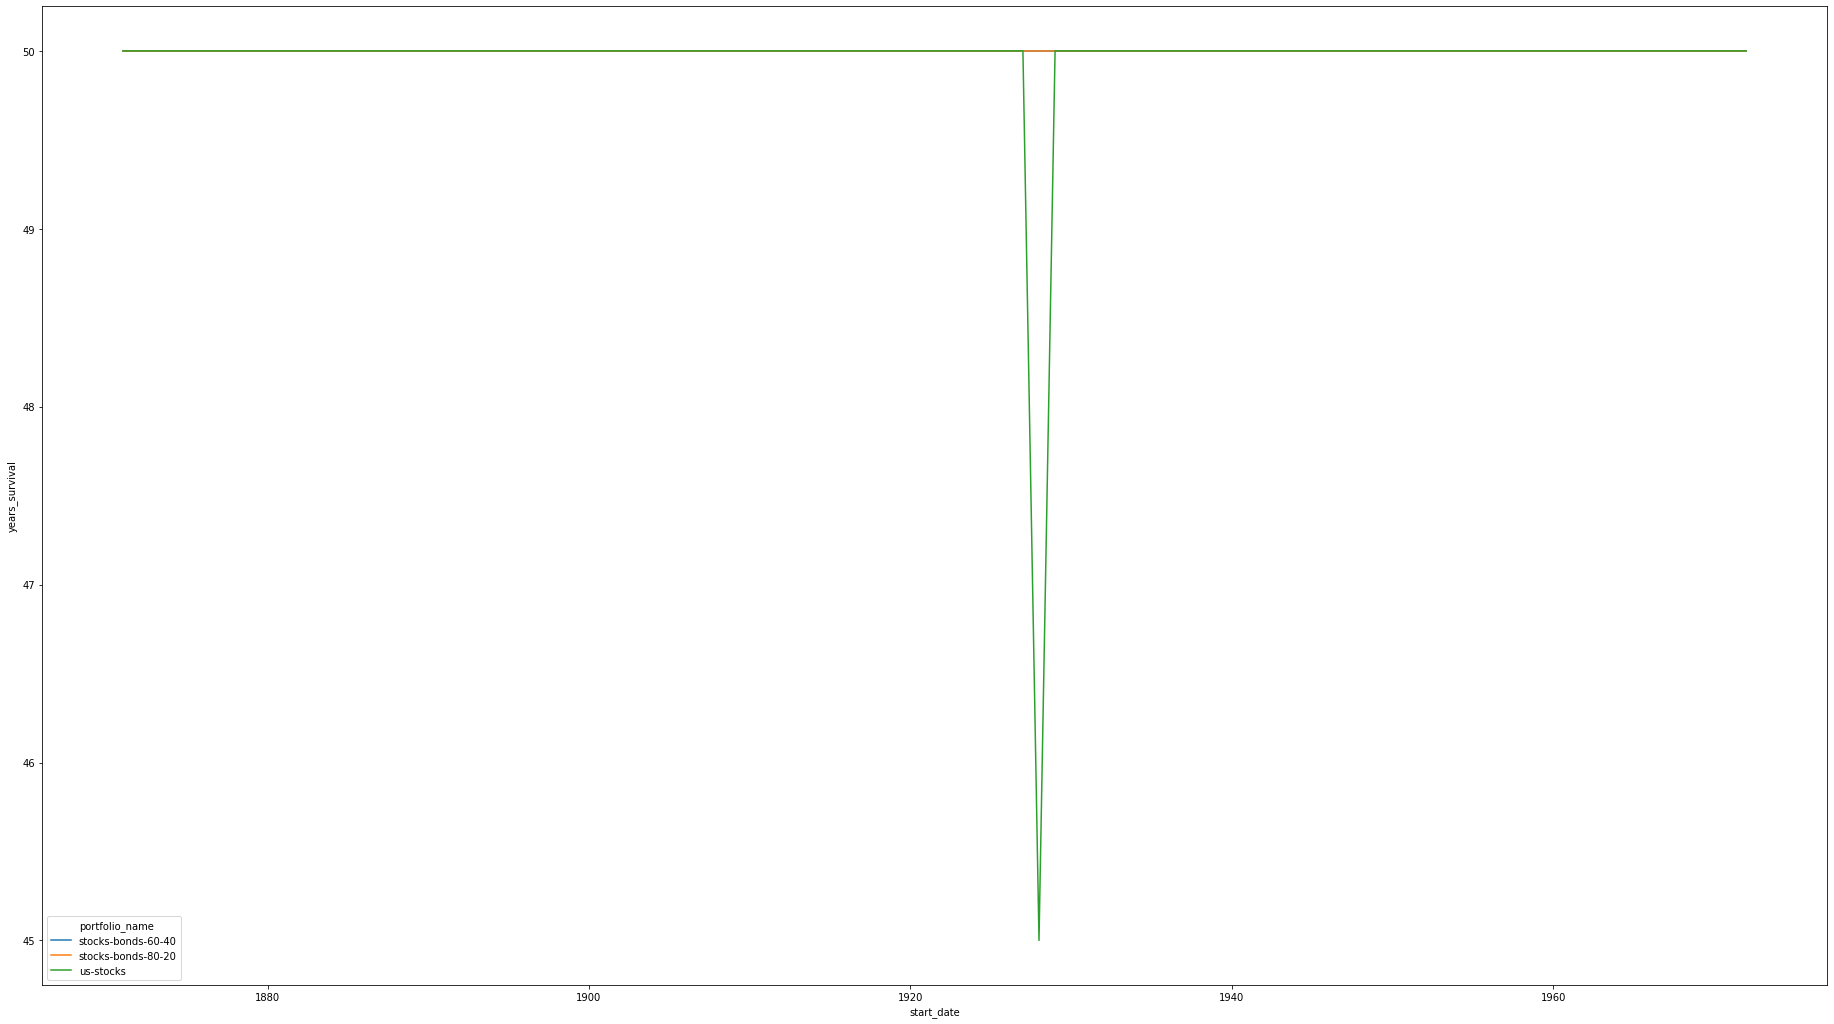

In [12]:
df2 = results_df[(results_df['withdrawal_years'] == 50) & (results_df['withdrawal_rate'] == 0.035) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'stocks-bonds-60-40', 'us-stocks']))]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df2) 
plt.show()

As you can see, almost all investors could safely withdraw 3.5% a year from their portfolios for 50 years - **With a few exceptions**:

The investors that retired in the end of the great bull market of the 1920s (right before the crash of 1929) would run out of money after 45 years instead of 50. Having 20-40% of their portfolios in US Treasury bonds shielded all bond-holding investors from that crash.

Having a stock market crash early in your retirement years is very terminal to your wealth as we can see in this graph - The portfolio of these investors really never recovered after the crash of 1929.

But running out of money 5 years earlier than expected perhaps is not so bad? What if we try to increase the annual withdrawal rate from 3.5% to 4%? The graph below shows this scenario:

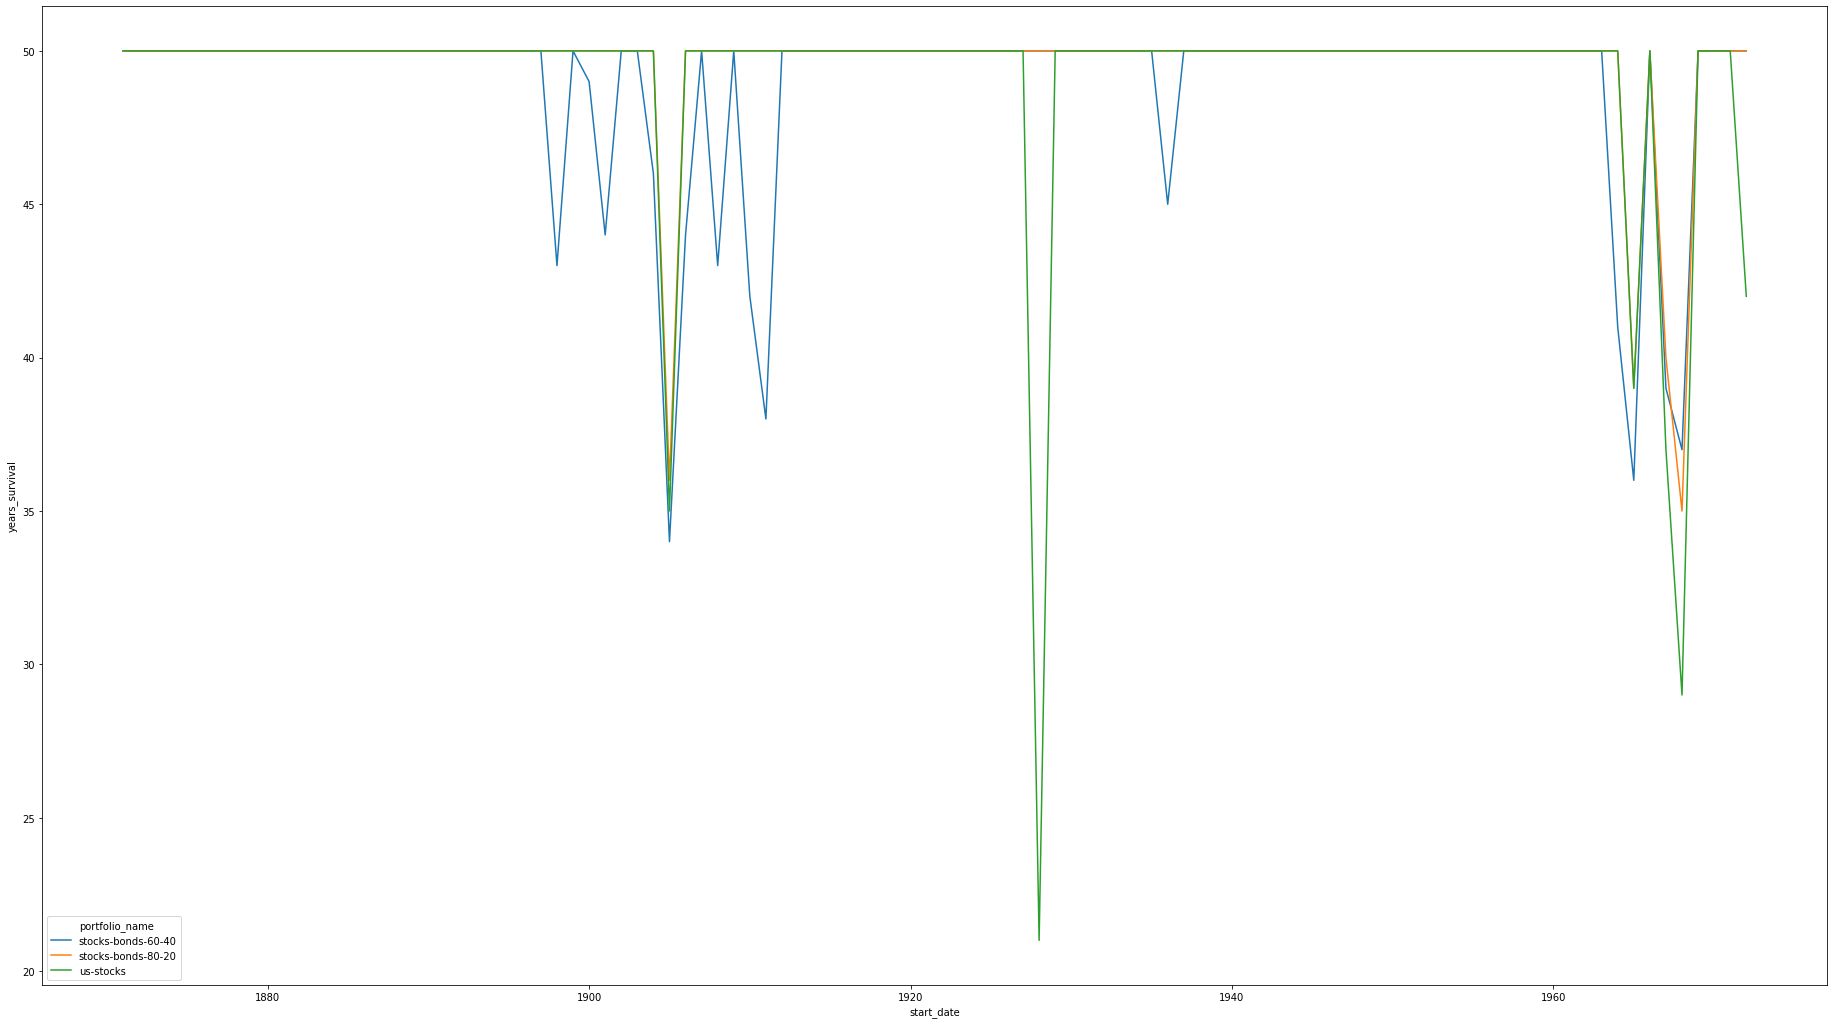

In [13]:
df3 = results_df[(results_df['withdrawal_years'] == 50) & (results_df['withdrawal_rate'] == 0.04) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'stocks-bonds-60-40', 'us-stocks']))]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df3) 
plt.show()

From this graph we can make a few conclusions:

- Having a higher share of US Treasury bonds in the portfolio is negative - In the late last decade of the 19th century and the first decade of the 20th century owning too much bonds proved to be a bad thing. The same goes for the 1930s and the 1970s. This is probably because a lower share of US stocks means that these investors missed out on many large stock moves. Even in market crashes the 60/40-portfolio underperformed, probably because this portfolio failed to regain the lost ground in the following bull markets.
- The US Stock portfolio ran out of money after just 20 years for the unlucky retirees who retired right before the 1929 market crash. The portfolio had to withstand a larger withdrawal rate (4% compared to 3.5% in the previous graph) as well as the greatest stock market crash in history and this proved to be too much for the portfolio, severely affecting it's life expectancy.
- All portfolios had a reduced life expectancy at the turn of the 20th century. The stock market flatlined for almost two decades during this period and withdrawing as much as 4% annually of their portfolios shortened the life-length of the **US Stock** and **80/20** portfolios by 10 years. The same goes for the late 1960s and early 1970s - The investors retiring during this period would face another lost decade of the stock market, high inflation and low bond yields.
- The safest portfolio appears to be the **Stock/Bond 80/20 portfolio** - Almost all investors who used this portfolio would live for 50 years without ever running out of money the exceptions being the poor investors who happened to retire in the early 20th century or the late 1960s/early 1970s.

What if we increased the withdrawal rate even a bit more? Maybe, with a little bit of luck we would be able to avoid retiring in the worst of years thus increasing our withdrawal rates - The graph below show the portfolio life-lenghts for a 5% withdrawal rate:

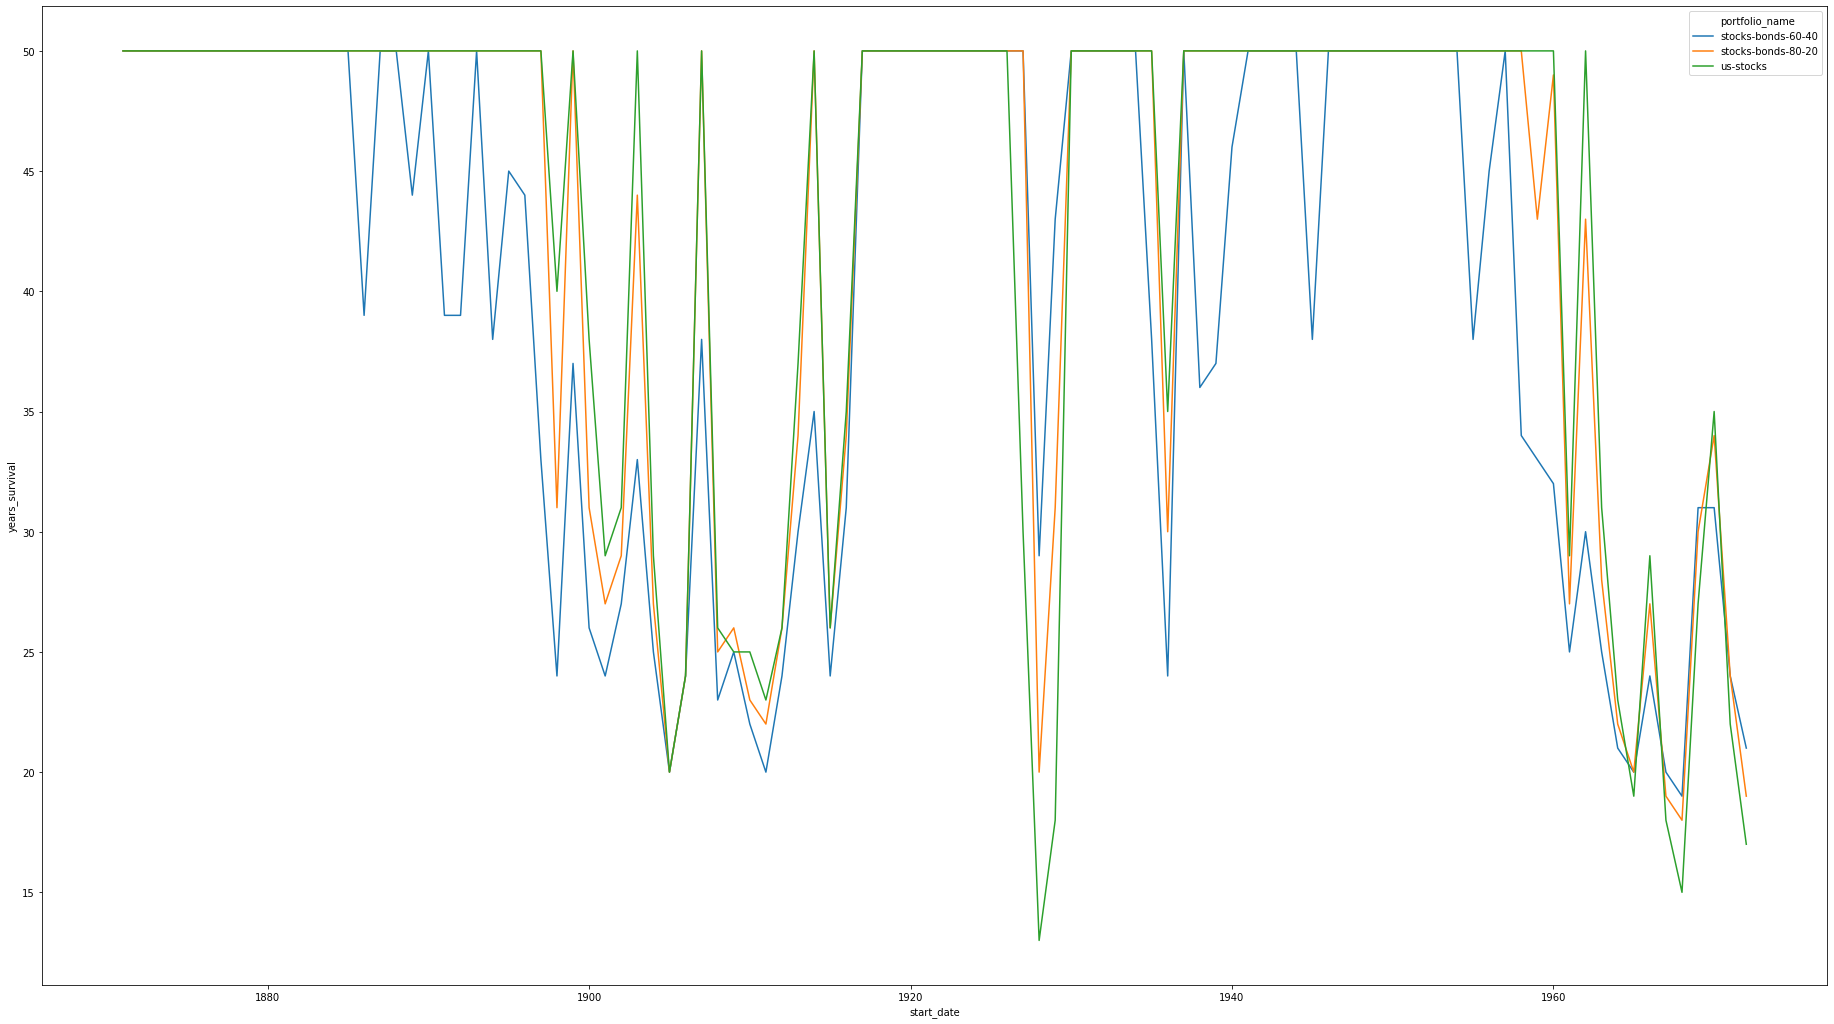

In [14]:
df4 = results_df[(results_df['withdrawal_years'] == 50) & (results_df['withdrawal_rate'] == 0.05) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'stocks-bonds-60-40', 'us-stocks']))]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df4) 
plt.show()

In this scenario it is the **US Stock** portfolio that outperforms. Except for the investors the retired right before the 1929 crash (they would run out of money after just 12 years) the investors who held a 100% US Stock portfolio would be best of. This is probably because the stock markets re-generative properties are much needed when the investors withdraws too much from their portfolios. The portfolios containing US Treasury bonds are never given the time to catch up after stock market crashes and therefore they will underperform (except in the 1929 crash when these portfolios would add another 10-20 years of economic freedom to their holders compared to the US Stock portfolio).

There is roughly a 50/50 chance that the investors who chooses to withdraw 5% annually can live happily without running out of money - If they are invested in at least 80% US stocks and as long as they didn't retire in the periods 1890-1915, right before the ourbreak of World War 2 or the 1970s.

But what if you believe that you can somewhat time the market? Lets say that you have been saving rigourously from a young age and therefore are free to choose when to retire and you can wait a few decades before starting withdrawing from your portfolio. Lets try to stretch the withdrawal rate to 7% in the graph below:

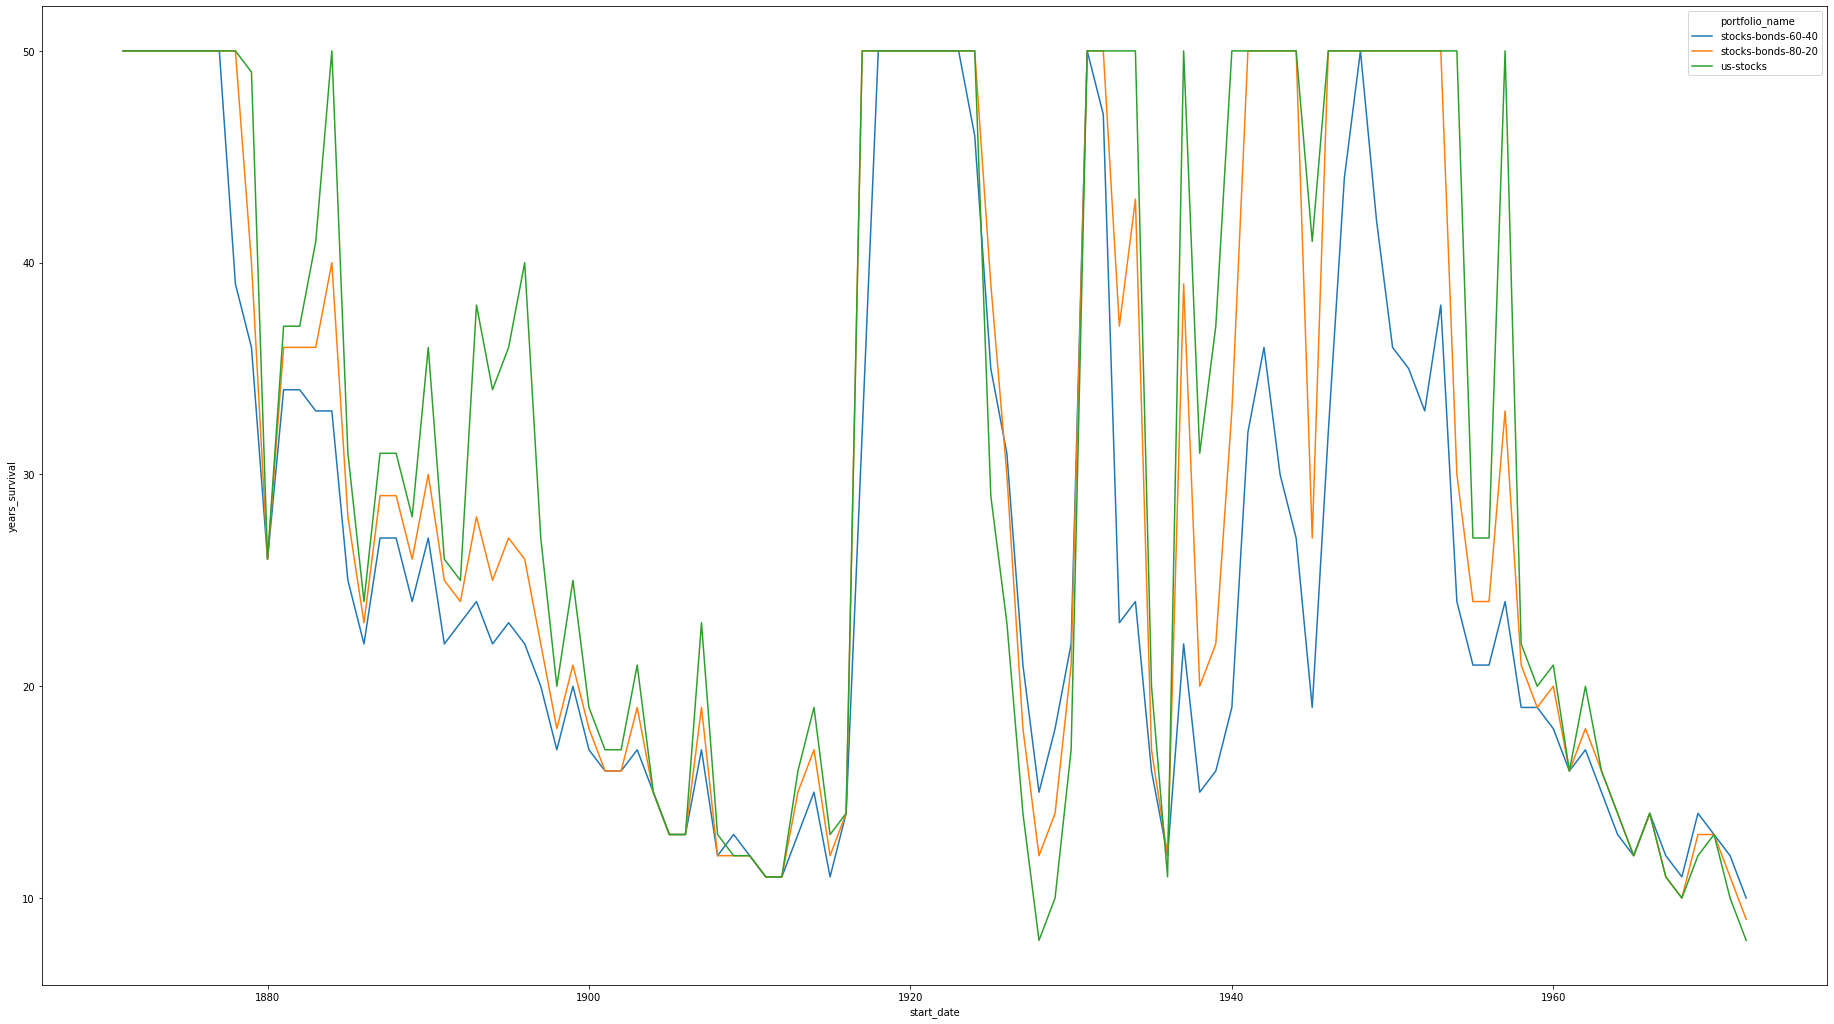

In [15]:
df5 = results_df[(results_df['withdrawal_years'] == 50) & (results_df['withdrawal_rate'] == 0.07) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'stocks-bonds-60-40', 'us-stocks']))]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df5) 
plt.show()

The graph shows that it might be possible to target low market valuations in order to give the portfolio the best possible start. But how would you do that?
It might be possible to use an stock market valuation index such as the [Shillers PE Ratio](https://www.multpl.com/shiller-pe). The Shiller PE Index tells investors to invest in the stock market whenever the index is beneath its historical average (which seems to be somewhere around 15). Of course, if you were able to invest when the Shiller PE Ratio reached absolute bottoms (beneath 10 or even 5) you would be guaranteed to retire without running out of money. But would you really be ready  to wait years for a PE Index bottom that never might come?
For example, the Shiller PE Ratio dived beneath 15 around 1905 and then continued to decline (along with the stock market) until the early 1920s and reaching an absolute bottom at 1921. However, if you failed to invest at the absolute bottom of the index, your portfolio would still be very short-lived (10-20 years).

But if we ignore this time period (1880s-1920) things look a bit brighter. If you were able to ride out the crash of 1929 unharmed and invested in the aftermath years you would have a good chance of living the rest of your days as financially independent. If you missed this opportunity you could wait another decade until the outbreak of World War II and invest then (when the rest of the market probably panicked and was afraid of investing). If you missed this opportunity, or spent your money building a bomb shelter instead, you could wait another decade until the early 1950s when the Shillers PE Index dropped below 15 once again.

If you are young and willing to wait one or two decades for favorable valuations of the stock market, and with a bit of luck, you can withdraw as much as 7% annually for the next 50 years. But this is a very risky move!

The investors who chooses to withdraw even more money - 8, 9 or even 10% annually would have to time the market perfectly in order to safely live of the portfolio for the next 50 year, which is close to impossible. The graph below shows how you would have to time the market with surgical precision with an withdrawal rate of 10%:

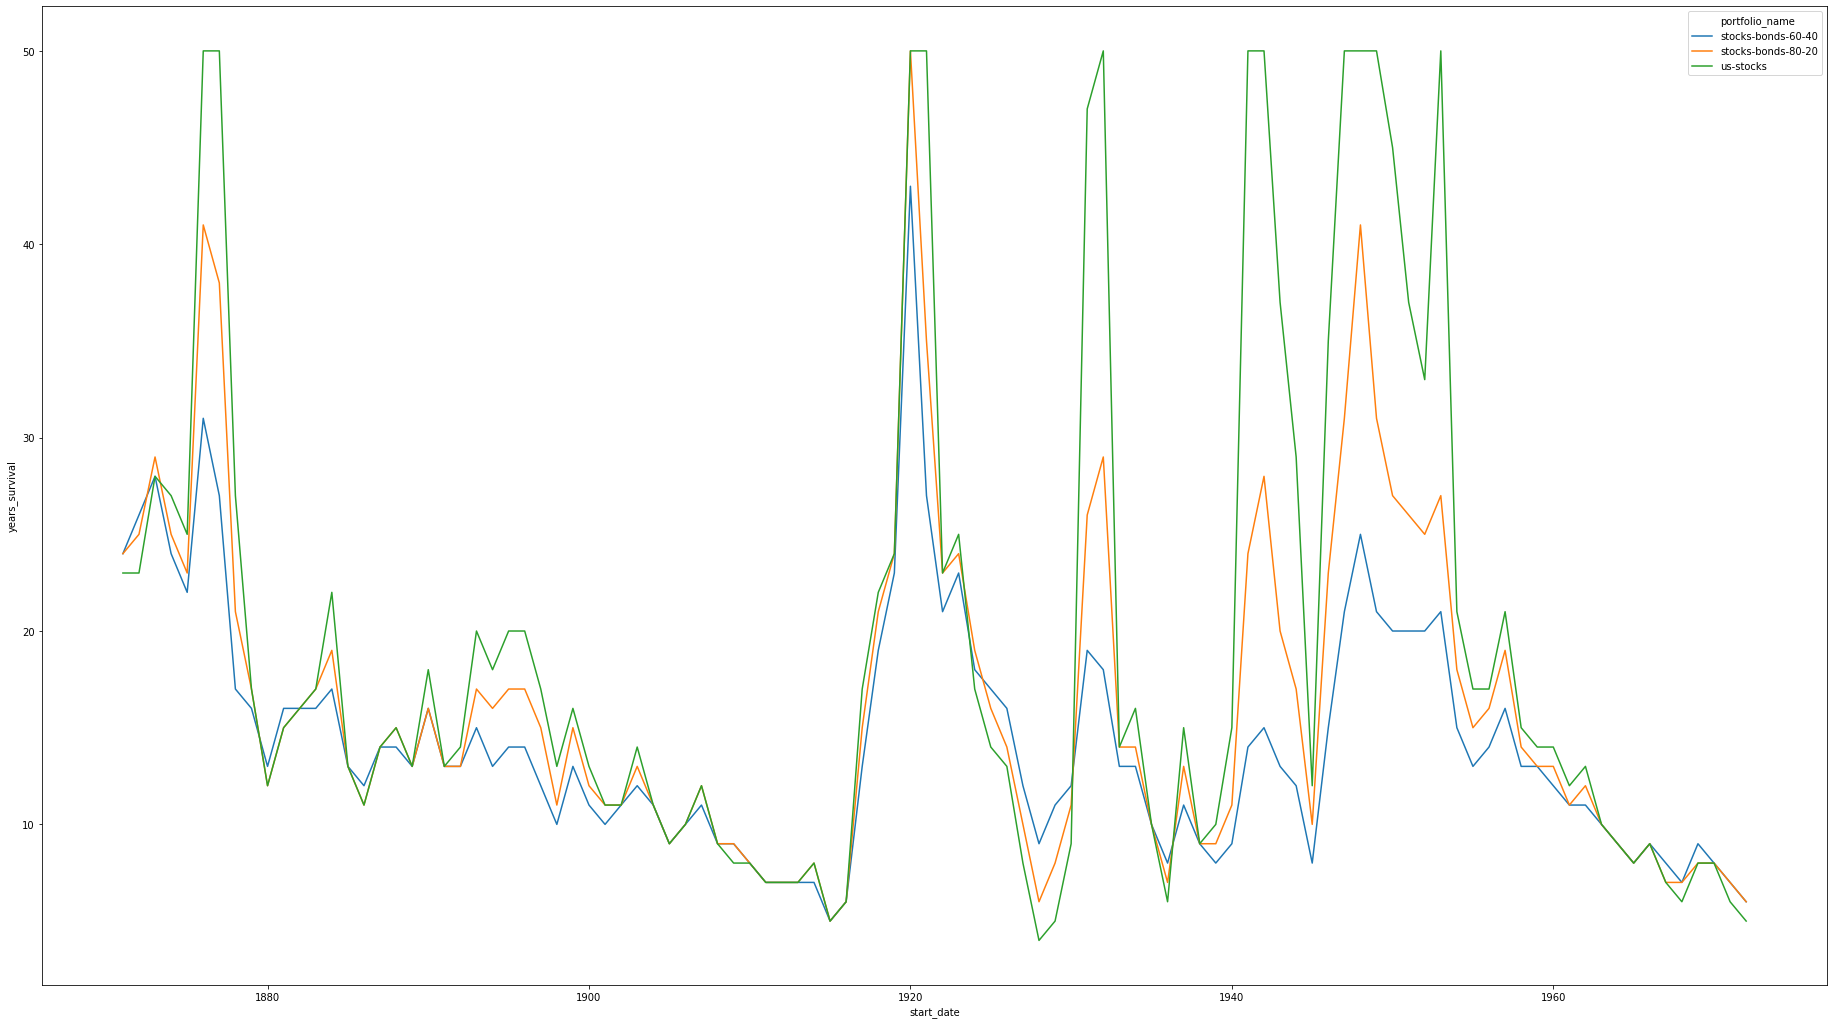

In [16]:
df5 = results_df[(results_df['withdrawal_years'] == 50) & (results_df['withdrawal_rate'] == 0.1) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'stocks-bonds-60-40', 'us-stocks']))]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df5) 
plt.show()

### How much money will you leave for your heirs?

One important question we want to know how much money is left in your portfolio when you pass away. Assuming you are convinced to use the optimal withdrawal rate of 3.5% a year the graph below shows how much money would be left in the portfolio 50 years later the investor retired:

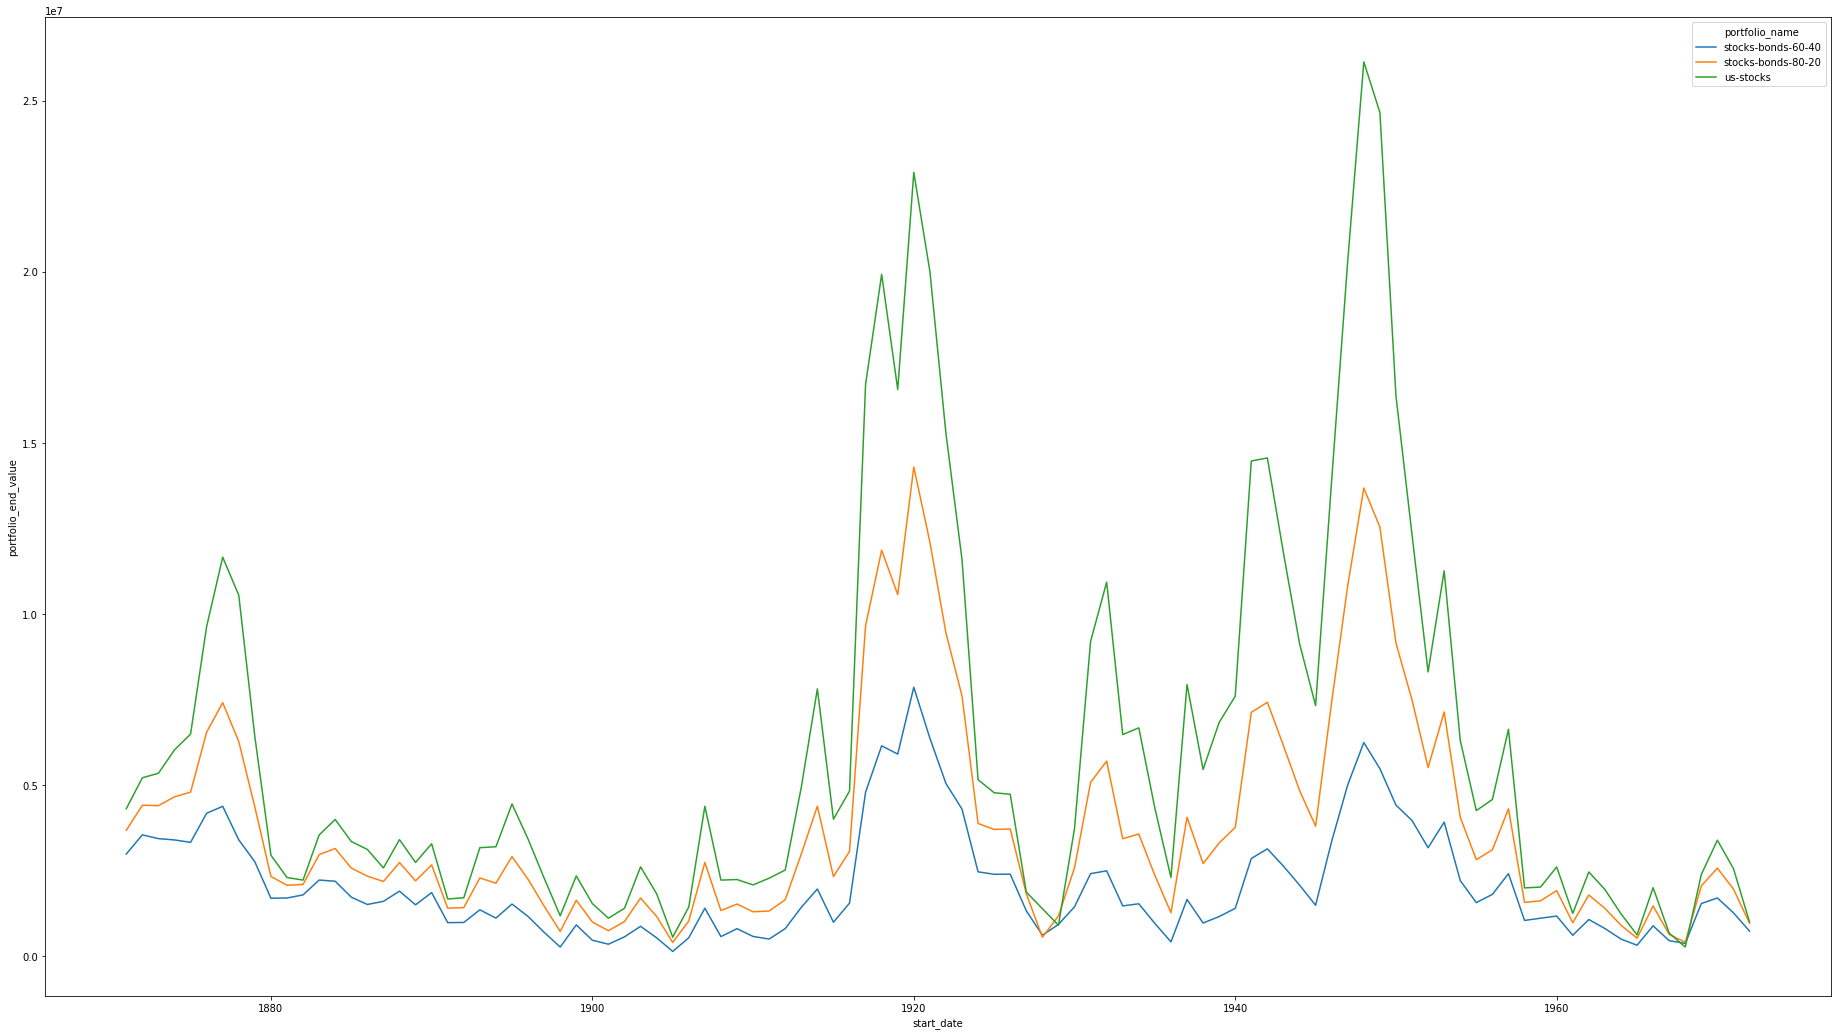

In [50]:
df6 = results_df[(results_df['withdrawal_years'] == 50) & (results_df['withdrawal_rate'] == 0.035) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'stocks-bonds-60-40', 'us-stocks'])) & (results_df['years_survival'] == 50)]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='portfolio_end_value', hue='portfolio_name', data=df6) 
plt.show()

Looking at the graph above we can clearly see that an 100% US Stock portfolio outperforms the bond-holding portfolios in all time periods and left anywhere between 1M and 25M SEK to the investors heirs. Looking back at the survival rate of the **US Stock** portfolio at an 3.5% withdrawal rate we can see that all investors managed to live off their portfolios for 50 years, except the investors who retired right before 1929 - They went bankrupt after 45 years. But if we really care about leaving more money to our heirs while at the same time accepting a slight risk of dying poor we should consider investing in an 100% **US Stock** portfolio.

#### What if I don't care about leaving money for my heirs?

But what if you don't care about leaving any money to your heirs? Then you could increase the annual withdrawal rate from your portfolio. Right?
Lets increase the annual withdrawal rate to >= 8% and look at the **US Stock** portfolios (this portfolio is the only option when using these high annual withdrawal rates) and make the assumption that we can live of the money in the portfolio our **last 10 years of life** instead of living of the portfolio yield. The graph below shows this:

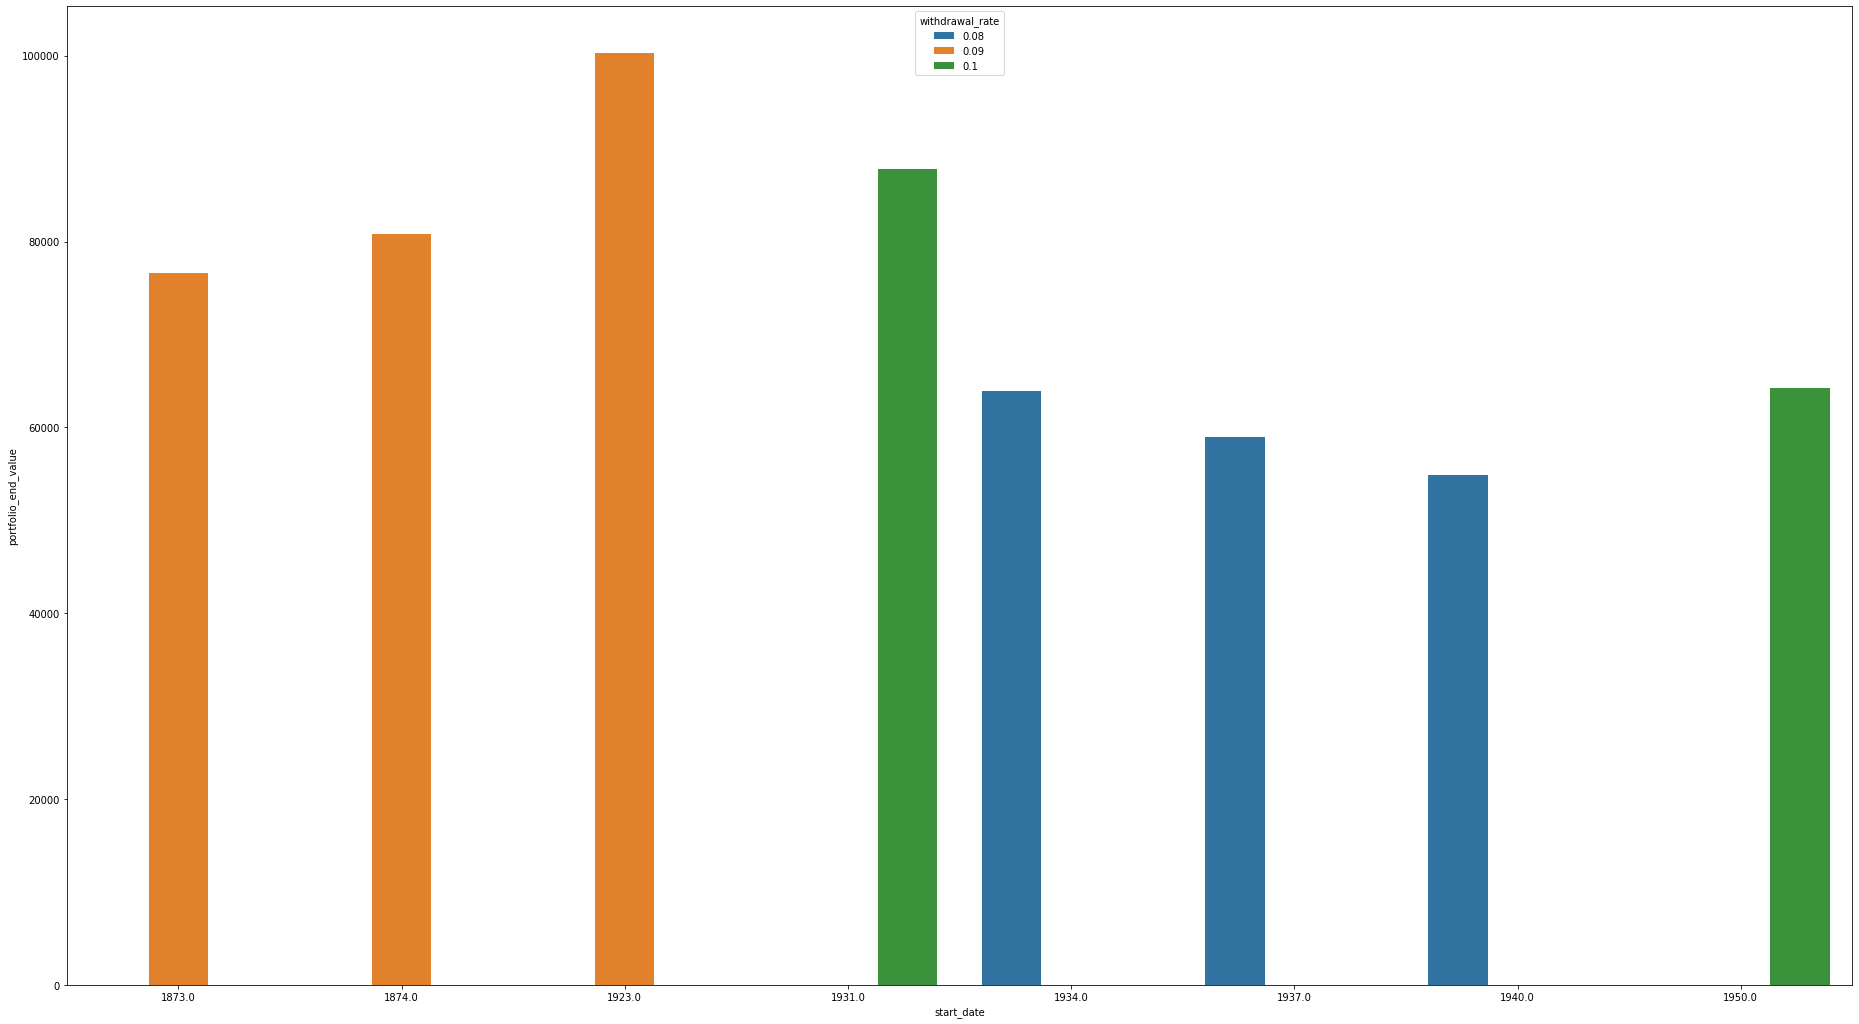

In [109]:
df7 = results_df[(results_df['withdrawal_years'] == 50) & (results_df['withdrawal_rate'] >= 0.08) & (results_df['portfolio_name'].isin(['us-stocks'])) & (results_df['years_survival'] >= 40) & (results_df['years_survival'] < 50)]
fig, ax = plt.subplots(figsize=(32,18))
sns.barplot(x='start_date', y='portfolio_end_value', hue='withdrawal_rate', data=df7) 
plt.show()

From the graph we can see some important things:

- Of all portfolios that didn't make it to 50 years only 8 bankrupted 10 years earlier
- It appears as if higher withdrawal rates (9% or 10%) leads to higher end value of the failed portfolio. However this is probably because the portfolio with lower withdrawal rates lived to 50 years and thus not showed in this graph

From this we can draw the conclusion that withdrawing the portfolio from the stock market and consume from it is **not an option**. The graph below shows the lifespan in years for all 8%-rate withdrawal portfolios that did not make it to 50 years and how much money they contained right before their bankrupcy:

In [ ]:
df8 = results_df[(results_df['withdrawal_years'] == 50) & (results_df['withdrawal_rate'] == 0.08) & (results_df['portfolio_name'].isin(['us-stocks'])) & (results_df['years_survival'] < 50)]
fig, ax = plt.subplots(figsize=(32,18))
sns.barplot(x='years_survival', y='portfolio_end_value', hue='withdrawal_rate', data=df8) 
plt.show()

KeyboardInterrupt: 

From this graph we can see that, at best, the retiree had at best 60K SEK to live of for the last 4 years of his life (since the most long-lived non-50-year portfolio managed to make it to 46 years and then contained ~60K SEK).